In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

In [21]:
def join_csv_files(data_path):
  """Joins all CSV files in a given directory into a single DataFrame.

  Args:
    data_path: The path to the directory containing the CSV files.

  Returns:
    A pandas DataFrame containing the combined data.
  """
  data_frames = []
  first_file = True

  for filename in os.listdir(data_path):
    if filename.endswith('.csv'):
      file_path = os.path.join(data_path, filename)
      df = pd.read_csv(file_path)

      if first_file:
        data_frames.append(df)
        first_file = False
      else:
        data_frames.append(df.iloc[1:])  # Skip the header in subsequent files

  if len(data_frames) > 0:
    return pd.concat(data_frames, ignore_index=True)
  else:
    print("No CSV files found in the directory.")
    return None

In [22]:
# Read the data from the CSV file
data_path = "../out/data/"
output_path = "../docs/res/plots/"

df_src = join_csv_files(data_path)

In [23]:
def exec_time(df):
    """Calculates the mean execution time for each group of rows with the same 
    Matrix Size, Threads, Function, and Implementation.

    Args:
        df (pandas.DataFrame): The DataFrame containing the data.

    Returns:
        pandas.DataFrame: A DataFrame with the calculated mean execution times.
    """
    
    # Calculate average execution time and standard deviation for each combination of Matrix Size, Function, and Implementation
    df_grouped = df.groupby(["Matrix Size", "Threads", "Function", "Implementation"])
    df_mean = df_grouped.mean().reset_index()

    # print(df_mean)

    return df_mean

In [24]:
df = exec_time(df_src)

In [25]:
def calculate_metrics(group):
    """
    Calculate speedup and efficiency for a given group of execution times.

    Parameters:
    group (pd.DataFrame): DataFrame containing execution times and implementation details.

    Returns:
    pd.Series: Series containing speedup and efficiency.
    """

    seq_time = group[group["Implementation"] == "SEQUENTIAL"]["Execution Time"].values[0]
    omp_time = group[group["Implementation"] == "OMP"]["Execution Time"].values[0]
    n_threads = group["Threads"].values[0]

    speedup = seq_time / omp_time
    efficiency = speedup / n_threads

    return pd.Series({"Speedup": speedup, "Efficiency": efficiency})

In [26]:
def calculate_speedup_efficiency(df):
    """Calculates the speedup and efficiency of the OpenMP implementation relative to the sequential implementation.

    Args:
        df: A pandas DataFrame containing the execution times for sequential and OpenMP implementations.

    Returns:
        A pandas DataFrame with columns for matrix size, number of threads, speedup, and efficiency.
    """

    df_filtered = df[df["Implementation"].isin(["SEQUENTIAL", "OMP"])]
    df_grouped = df_filtered.groupby(["Matrix Size", "Threads", "Function"])

    result_df = df_grouped.apply(calculate_metrics)
    
    return result_df.reset_index()

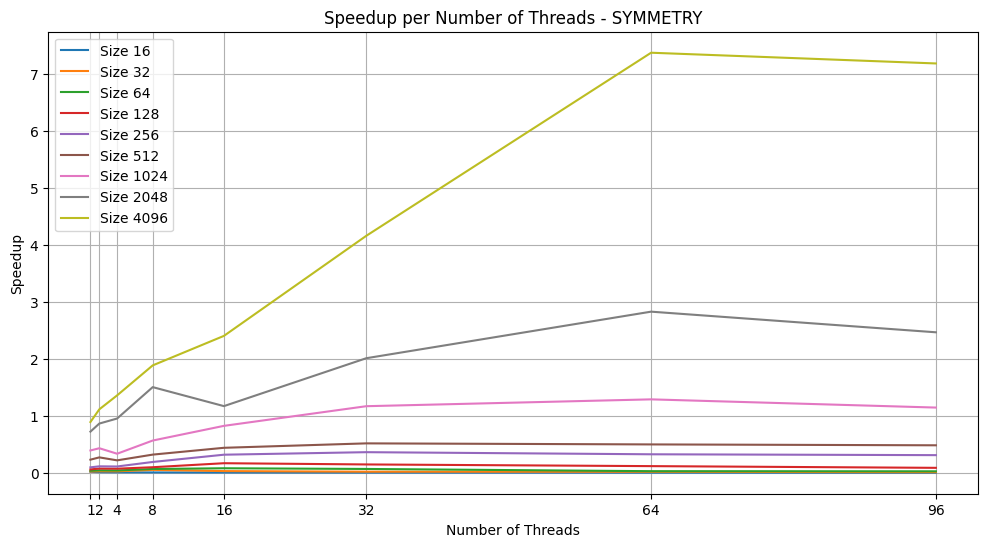

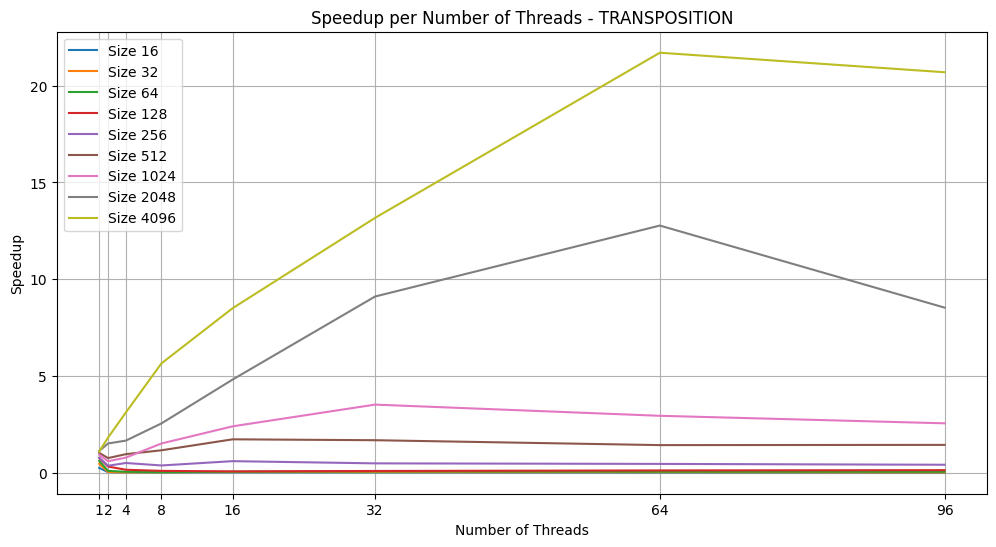

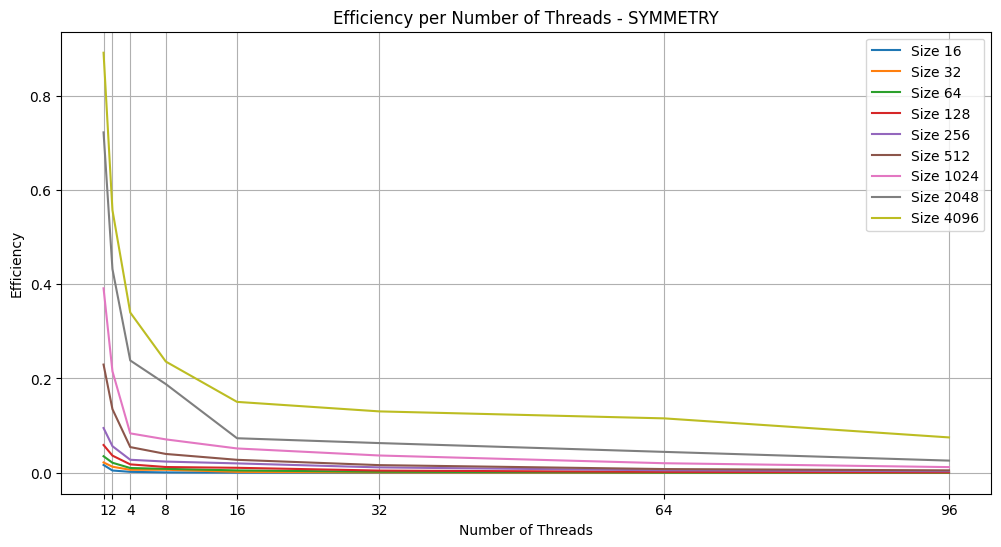

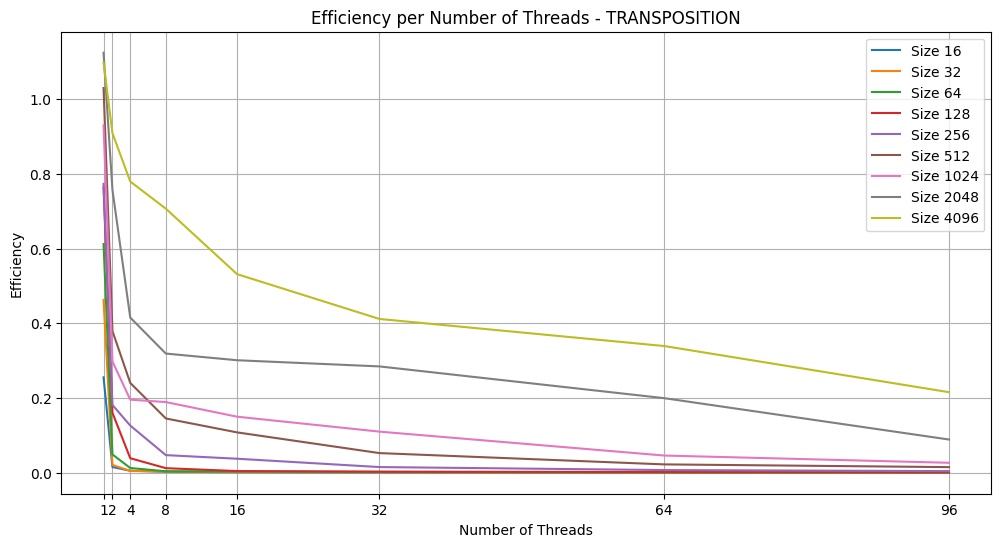

In [27]:
def plot_speedup_efficiency(df_speedup_efficiency):
    # Plot speedup vs. number of threads for different matrix sizes and implementations
    for func in df_speedup_efficiency["Function"].unique():
        plt.figure(figsize=(12, 6))
        for size in df_speedup_efficiency["Matrix Size"].unique():
            data = df_speedup_efficiency[(df_speedup_efficiency["Matrix Size"] == size) & (df_speedup_efficiency["Function"] == func)]
            plt.plot(data["Threads"], data["Speedup"], label=f"Size {size}")

        plt.xticks([1, 2, 4, 8, 16, 32, 64, 96])
        plt.xlabel("Number of Threads")
        plt.ylabel("Speedup")
        plt.title(f"Speedup per Number of Threads - {func}")
        plt.legend()
        plt.grid(True)
        # plt.show()
        plt.savefig(f"{output_path}/speedup_{func}.png")

    # Plot efficiency vs. number of threads for different matrix sizes and implementations
    for func in df_speedup_efficiency["Function"].unique():
        plt.figure(figsize=(12, 6))
        for size in df_speedup_efficiency["Matrix Size"].unique():
            data = df_speedup_efficiency[(df_speedup_efficiency["Matrix Size"] == size) & (df_speedup_efficiency["Function"] == func)]
            plt.plot(data["Threads"], data["Efficiency"], label=f"Size {size}")

        plt.xticks([1, 2, 4, 8, 16, 32, 64, 96])
        plt.xlabel("Number of Threads")
        plt.ylabel("Efficiency")
        plt.title(f"Efficiency per Number of Threads - {func}")
        plt.legend()
        plt.grid(True)
        plt.savefig(f"{output_path}/efficiency_{func}.png")
        # plt.show()

plot_speedup_efficiency(calculate_speedup_efficiency(df))

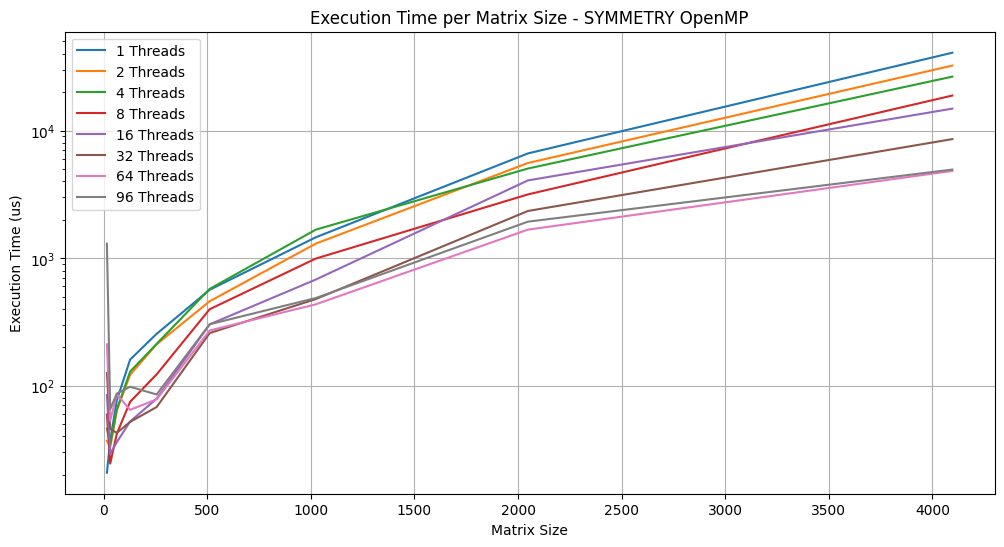

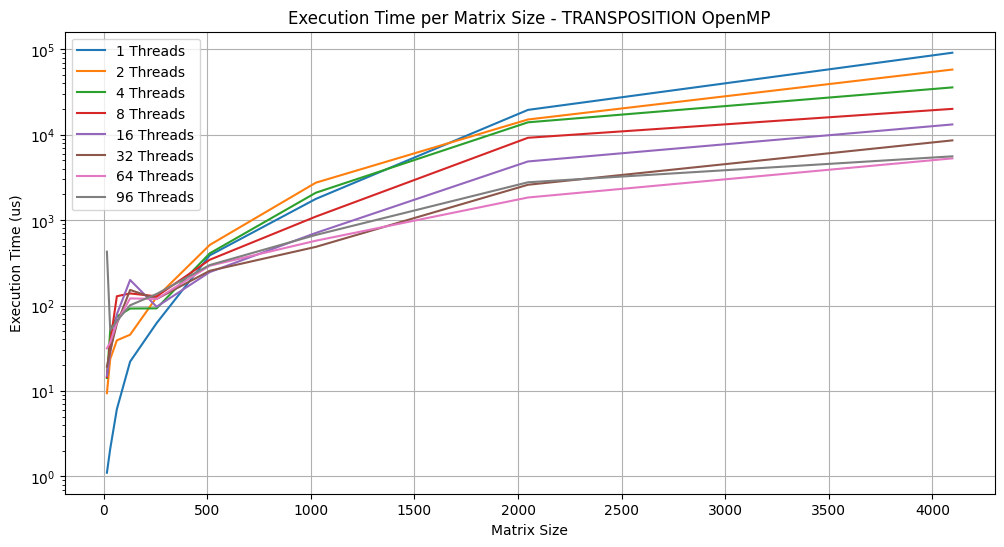

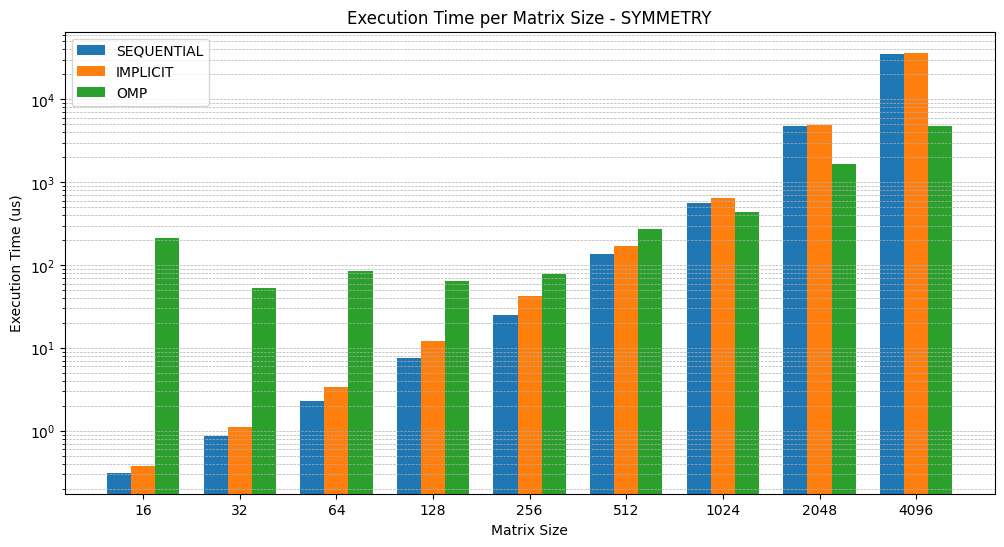

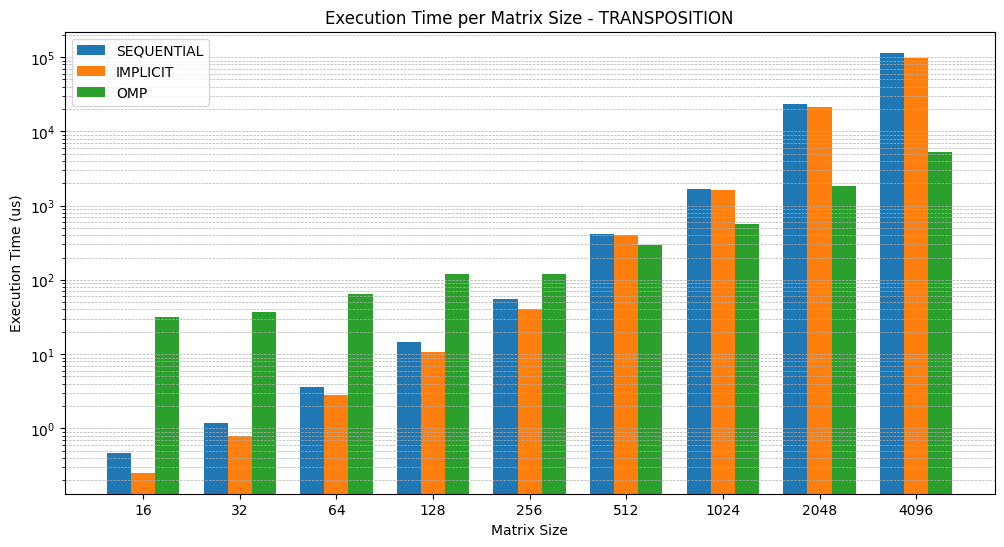

In [28]:
def plot_exec_time_omp(df):
    omp = df[df["Implementation"] == "OMP"]

    for func in omp["Function"].unique():
        plt.figure(figsize=(12, 6))

        for num_threads in omp["Threads"].unique():
            data = omp[omp["Threads"] == num_threads]
            plt.plot(data["Matrix Size"], data["Execution Time"] * 1e6, label=f"{num_threads} Threads")
        
        plt.xlabel("Matrix Size")
        plt.ylabel("Execution Time (us)")
        plt.yscale("log")
        plt.title(f"Execution Time per Matrix Size - {func} OpenMP")
        plt.legend()
        plt.grid(True)
        plt.savefig(f"{output_path}/exec_time_{func}_omp.png")
        # plt.show()


def plot_barplot(df, title):
    df_by_thread = df[df["Threads"] == 64]
    df_by_thread = df_by_thread[df_by_thread["Matrix Size"] > 0]
    omp = df_by_thread[(df_by_thread["Implementation"] == "OMP")]
    seq = df_by_thread[(df_by_thread["Implementation"] == "SEQUENTIAL")]
    implicit = df_by_thread[(df_by_thread["Implementation"] == "IMPLICIT")]

    bar_width = 2
    group_spacing = 2
    x_values = np.arange(len(df_by_thread["Matrix Size"].unique())) * (3 * bar_width + group_spacing)
    
    plt.figure(figsize=(12, 6))
    # use row index as x values
    plt.xticks(x_values, omp["Matrix Size"])
    plt.xlabel("Matrix Size")
    plt.ylabel("Execution Time (us)")
    plt.yscale("log")
    plt.title(f"Execution Time per Matrix Size - {title}")
    plt.bar(x_values - bar_width, seq["Execution Time"] * 1e6, bar_width, label=("SEQUENTIAL"))
    plt.bar(x_values, implicit["Execution Time"] * 1e6, bar_width, label=("IMPLICIT"))
    plt.bar(x_values + bar_width, omp["Execution Time"] * 1e6, bar_width, label=("OMP"))
    plt.legend()
    plt.grid(True, which='both', axis='y', ls="--", linewidth=0.5, zorder=0)
    plt.savefig(f"{output_path}/exec_time_{title}.png")
    # plt.show()

def plot_execution_time(df):
    df_symmetry = df[df["Function"] == "SYMMETRY"]
    df_transposition = df[df["Function"] == "TRANSPOSITION"]

    plot_exec_time_omp(df_symmetry)
    plot_exec_time_omp(df_transposition)
    plot_barplot(df_symmetry, "SYMMETRY")
    plot_barplot(df_transposition, "TRANSPOSITION")

plot_execution_time(df)